In [1]:
# General
import os
import pandas as pd
import numpy as np
import math
import sys
import time
import pickle
import json
import datetime
import random
import seaborn as sns

#import sklearn
import sklearn
from sklearn import *

#import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load a set of pickle files, put them together in a single DataFrame, and order them by time
# It takes as input the folder DIR_INPUT where the files are stored, and the BEGIN_DATE and END_DATE
def read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE):
    
    files = [os.path.join(DIR_INPUT, f) for f in os.listdir(DIR_INPUT) if f>=BEGIN_DATE+'.pkl' and f<=END_DATE+'.pkl']

    frames = []
    for f in files:
        df = pd.read_pickle(f)
        frames.append(df)
        del df
    df_final = pd.concat(frames)
    
    df_final=df_final.sort_values('TRANSACTION_ID')
    df_final.reset_index(drop=True,inplace=True)
    #  Note: -1 are missing values for real world data 
    df_final=df_final.replace([-1],0)
    
    return df_final

In [3]:
DIR_INPUT='../simulated-data-transformed/data/' 

BEGIN_DATE = "2018-04-01"
END_DATE = "2018-09-30"

print("Load  files")
%time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

Load  files
Wall time: 9.56 s
1754155 transactions loaded, containing 14681 fraudulent transactions


In [4]:
transactions_df.head()


,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,...,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0,0,0,1,...,1.0,57.16,1.0,57.16,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0,0,1,...,1.0,81.51,1.0,81.51,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0,0,0,1,...,1.0,146.00,1.0,146.00,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0,0,1,...,1.0,64.49,1.0,64.49,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0,0,0,1,...,1.0,50.99,1.0,50.99,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
transactions_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754155 entries, 0 to 1754154
Data columns (total 23 columns):
 #   Column                               Dtype         
---  ------                               -----         
 0   TRANSACTION_ID                       int64         
 1   TX_DATETIME                          datetime64[ns]
 2   CUSTOMER_ID                          int64         
 3   TERMINAL_ID                          int64         
 4   TX_AMOUNT                            float64       
 5   TX_TIME_SECONDS                      int64         
 6   TX_TIME_DAYS                         int64         
 7   TX_FRAUD                             int64         
 8   TX_FRAUD_SCENARIO                    int64         
 9   TX_DURING_WEEKEND                    int64         
 10  TX_DURING_NIGHT                      int64         
 11  CUSTOMER_ID_NB_TX_1DAY_WINDOW        float64       
 12  CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW   float64       
 13  CUSTOMER_ID_NB_TX_7DAY_WIND

## Class Distribution

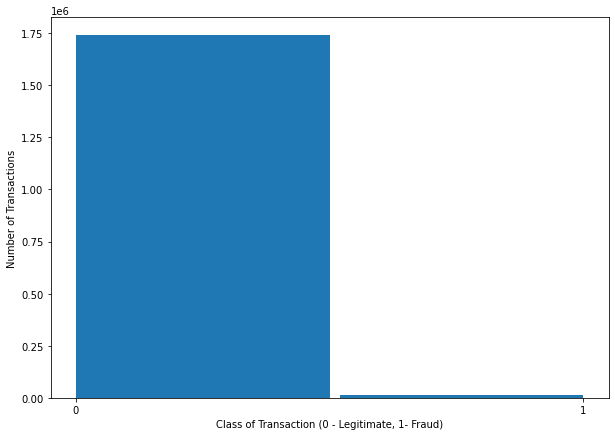

In [6]:
x=transactions_df["TX_FRAUD"]
# Creating histogram
bins=np.linspace(0, 1, num=3)
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(x,bins=[0,0.5,0.52,1])
plt.xlabel("Class of Transaction (0 - Legitimate, 1- Fraud)")
plt.ylabel("Number of Transactions")
plt.xticks([0,1])
# Show plot
plt.show()

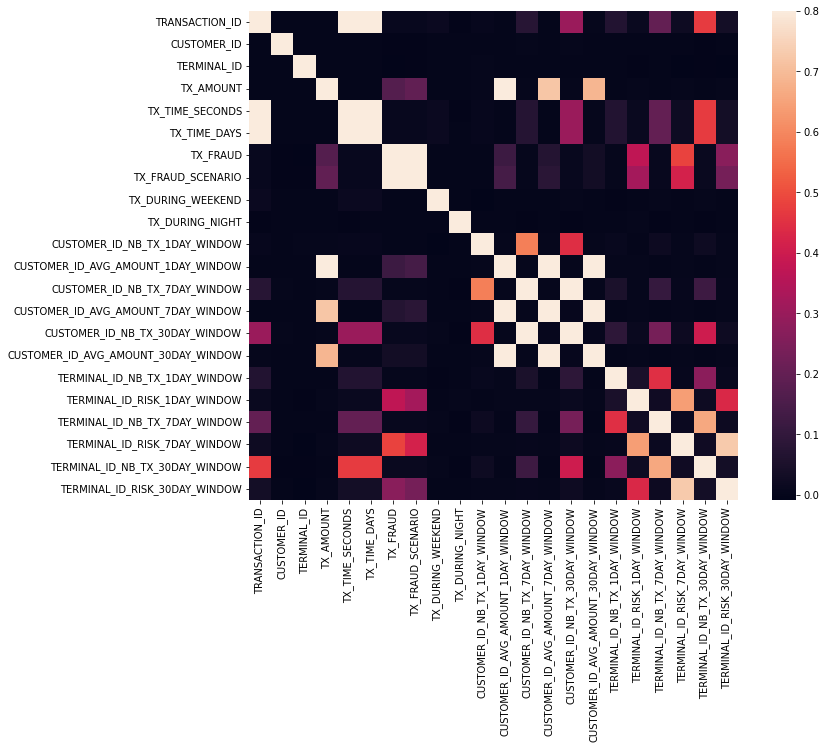

In [7]:
# Correlation matrix
corrmat = transactions_df.corr()
fig = plt.figure(figsize = (12, 9))
sns.heatmap(corrmat, vmax = .8, square = True)
plt.show()

In [8]:
# dividing the X and the Y from the dataset
X = transactions_df.drop(['TX_FRAUD'], axis = 1)
Y = transactions_df["TX_FRAUD"]
X=X.drop(['TX_DATETIME'],axis=1)
X=X.drop(['TX_FRAUD_SCENARIO'],axis=1)
print(X.shape)
print(Y.shape)
# getting just the values for the sake of processing 
# (its a numpy array with no columns)
xData = X.values
yData = Y.values

(1754155, 20)
(1754155,)


##  Decision Tree

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
clf=DecisionTreeClassifier()
xTrain, xTest, yTrain, yTest = train_test_split(
        X, Y, test_size = 0.2, random_state = 42)
clf.fit(xTrain,yTrain)



DecisionTreeClassifier()

In [10]:
# Evaluating the classifier
# printing every score of the classifier
# scoring in anything
from sklearn.metrics import classification_report, accuracy_score 
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix
  
fraud=14681
yPred=clf.predict(xTest)
n_errors = (yPred != yTest).sum()
print("The model used is Random Forest classifier")
  
acc = accuracy_score(yTest, yPred)
print("The accuracy is {}".format(acc))
  
prec = precision_score(yTest, yPred)
print("The precision is {}".format(prec))
  
rec = recall_score(yTest, yPred)
print("The recall is {}".format(rec))
  
f1 = f1_score(yTest, yPred)
print("The F1-Score is {}".format(f1))

The model used is Random Forest classifier
The accuracy is 0.9943733592527456
The precision is 0.6441737985516788
The recall is 0.6866666666666666
The F1-Score is 0.6647418478260869


In [11]:
# Now we see that the all the precision scores are pretty good.
# This may seem like a very good and accurate model training, however this is not the case.
# The potential accuracy of this model is due to the high imbalance of the dataset.
# Thus to make a effecient data set we are going to perform under sampling

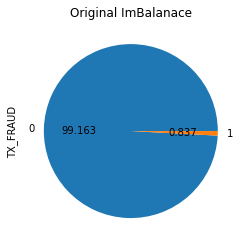

In [12]:
#distribution before undersampling
ax = Y.value_counts().plot.pie(autopct='%.3f')
_ = ax.set_title("Original ImBalanace")

In [13]:
#class distribution
Y.value_counts()

0    1739474
1      14681
Name: TX_FRAUD, dtype: int64

## Random Under Sampling

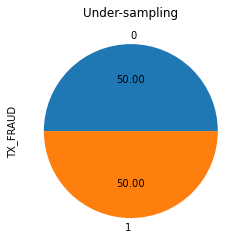

In [14]:
# Random Undersampling 
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=1) # Numerical value
# rus = RandomUnderSampler(sampling_strategy="not minority") # String
X_res, y_res = rus.fit_resample(X, Y)
ax = y_res.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Under-sampling")

In [15]:
#class distribution
y_res.value_counts()

0    14681
1    14681
Name: TX_FRAUD, dtype: int64

In [34]:
# Using Scikit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
drop_indices = np.random.choice(y_res.index, 7000, replace=False)
xTrain, xTest, yTrain, yTest_res = train_test_split(
        X_res, y_res, test_size = 0.2)

## Random Cut Forest

In [36]:
# Building the Random Forest Classifier (RANDOM FOREST)
from sklearn.ensemble import RandomForestClassifier
# random forest model creation
rfc_rus = RandomForestClassifier()
rfc_rus.fit(xTrain, yTrain)
# predictions
yPred_res = rfc_rus.predict(xTest)

In [37]:
fraud=14681
n_errors = (yPred_res != yTest_res).sum()
print("The model used is Random Forest classifier")
  
acc = accuracy_score(yTest_res, yPred_res)
print("The accuracy is {}".format(acc))
  
prec = precision_score(yTest_res, yPred_res)
print("The precision is {}".format(prec))
  
rec = recall_score(yTest_res, yPred_res)
print("The recall is {}".format(rec))
  
f1 = f1_score(yTest_res, yPred_res)
print("The F1-Score is {}".format(f1))


The model used is Random Forest classifier
The accuracy is 0.8848969862080708
The precision is 0.9744234800838575
The recall is 0.7907451514120449
The F1-Score is 0.8730277986476334


## Decision Tree


In [31]:
clf_rus=DecisionTreeClassifier()
xTrain, xTest, yTrain, yTest = train_test_split(
        X_res, y_res, test_size = 0.2, random_state = 42)
clf_rus.fit(xTrain,yTrain)

DecisionTreeClassifier()

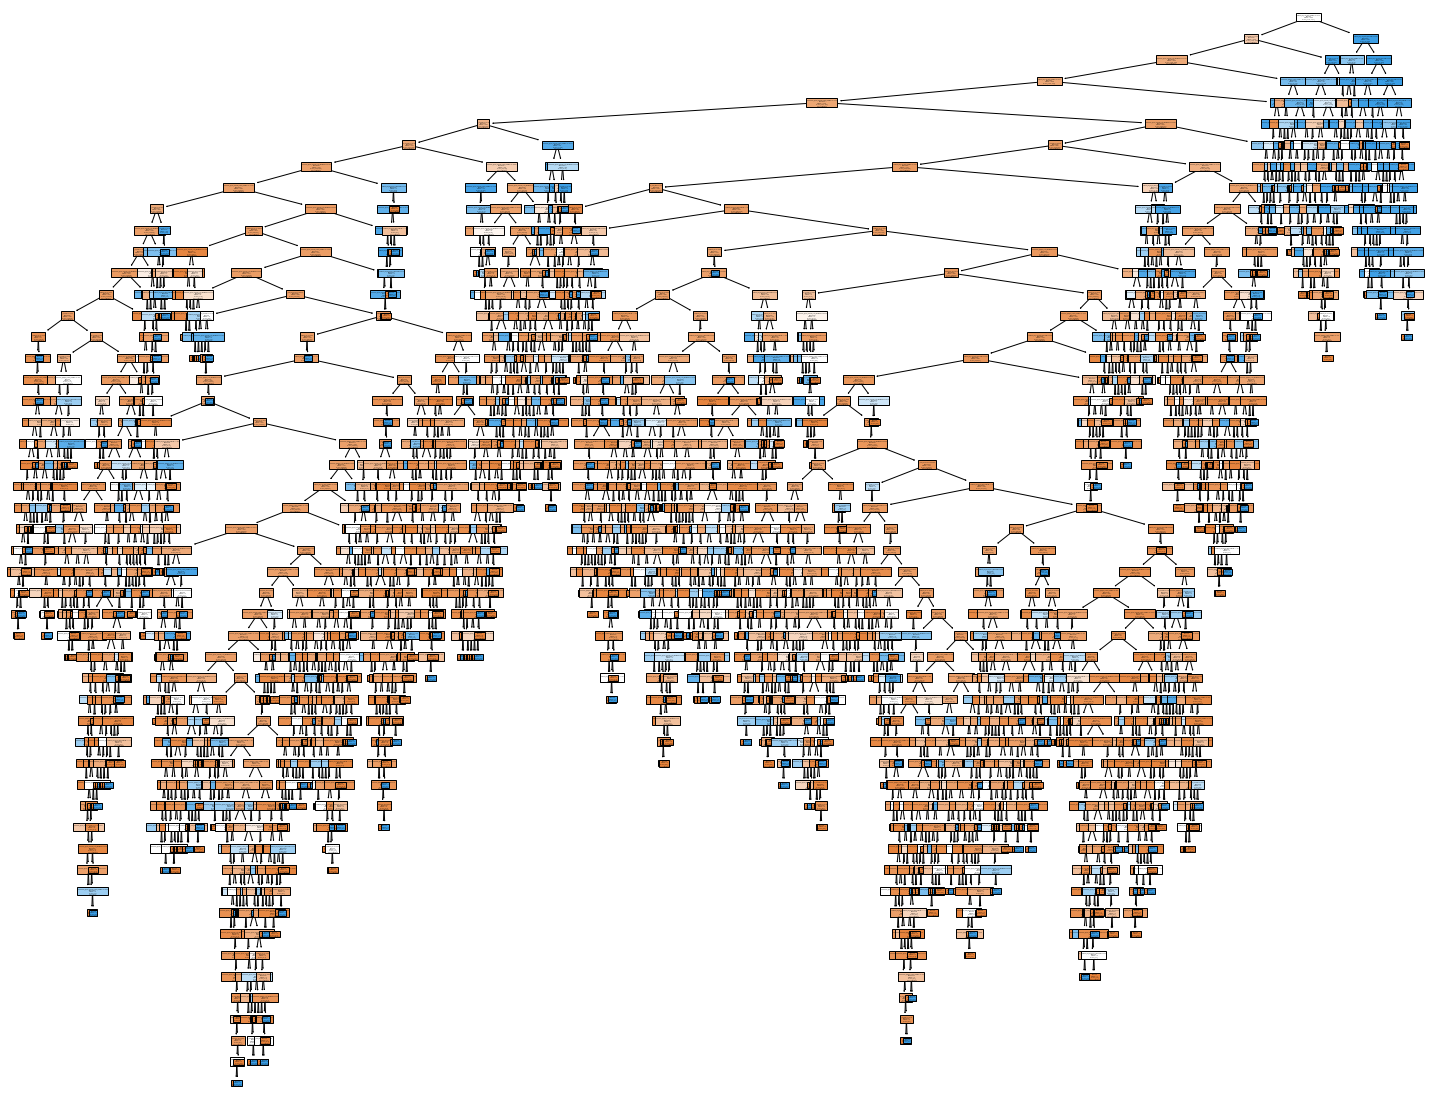

In [20]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf_rus, 
                   feature_names=X_res.columns,  
                   class_names=["Legitimate","Fraud"],
                   filled=True)

In [32]:
yPred=clf_rus.predict(xTest)
fraud=14681
n_errors = (yPred != yTest).sum()
print("The model used is Random Forest classifier")
  
acc = accuracy_score(yTest, yPred)
print("The accuracy is {}".format(acc))
  
prec = precision_score(yTest, yPred)
print("The precision is {}".format(prec))
  
rec = recall_score(yTest, yPred)
print("The recall is {}".format(rec))
  
f1 = f1_score(yTest, yPred)
print("The F1-Score is {}".format(f1))

The model used is Random Forest classifier
The accuracy is 0.8169589647539588
The precision is 0.8136894824707847
The recall is 0.8249830737982397
The F1-Score is 0.8192973609009918


However even after doing undersampling, we see that the performance metrics have improved.
Now this might be correct but before drawing any conclusion about our model we need to understand the performance metrics in use. 
The recall, specificity, precision, and F1 score metrics, also known as threshold-based metrics, have well-known limitations due to their dependence on a decision threshold which is difficult to determine in practice, and strongly depends on the business-specific constraints.
Hence to present an appropriate image of our model we need to use threshhold free metrics such as AUC ROC and AP, for our analysis.

In [38]:
from sklearn.metrics import roc_auc_score

auc_clf = roc_auc_score(yTest, yPred)
auc_rfc = roc_auc_score(yTest_res, yPred_res)

print("AUC SCORE FOR DECISION TREE CLASSIFIER: ",auc_clf)
print("AUC SCORE FOR RFC: ",auc_rfc)



AUC SCORE FOR DECISION TREE CLASSIFIER:  0.8169108585846285
AUC SCORE FOR RFC:  0.8849772110161792


The ROC AUC score tells us how efficient the model is. The higher the AUC, the better the model's performance at distinguishing between the positive and negative classes. An AUC score of 1 means the classifier can perfectly distinguish between all the Positive and the Negative class points.


Even though the accuracies for the two models are similar, the model with the higher AUC score will be more reliable because it takes into account the predicted probability. It is more likely to give you higher accuracy when predicting future data.

## Saving the models

In [40]:
#Saving the trained models
pickle.dump(clf_rus, open('./Trained_Models/DecisionTreemodel.pkl', 'wb'))
pickle.dump(rfc_rus, open('./Trained_Models/RFCmodel.pkl', 'wb'))